Now that we've settled on our final model, let us start putting together what we'll use for the app.

Ultimately this file just contains my 'sketches' at trying to plan how I'll put everything together. I may even just delete this/add it to the gitignore.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from bs4 import BeautifulSoup
import regex as re
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

from random import choices

import pickle

In [7]:
with open('model_base.pkl', 'rb') as f: #reading bytes
    foo = pickle.load(f)

In [8]:
df = pd.read_csv('../data/cleaned_02_ii.csv')
print(df.shape)
df.head()

(39565, 60)


,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
0,0,White people are trash.,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,white peopl are trash,4
1,0,"You've caught the big gay, it's known to be ai...",0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,you ve caught the big gay it s known to be air...,14
2,0,"I'm not saying you said that, I'm just saying ...",-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,i m not say you said that i m just say that if...,75
3,0,Donald Trump. Yeet myself off a building onto ...,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,donald trump yeet myself off a build onto a ga...,20
4,0,Fabrice Fabrice is ostensibly black or black/l...,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,fabric fabric is ostens black or black latino ...,19


In [9]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 3785, #To have a clean 200 2s in the test 3785 pref
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

In [10]:
data = pd.DataFrame(X_train)
data['hate_rank'] = y_train
data_names = []
for i in range(3):
    data_names.append(f"data_{i}")
col_size = 4000
for i in range(len(data_names)):#Recall that we're still planning on doing replace=True even for 0.
    data_names[i] = data[data['hate_rank']==i].sample(col_size, replace=True, random_state=26)
data = pd.concat(data_names)
print(data.shape)
data.head()

(12000, 2)


,cleaned_text,hate_rank
9021,i doubt satan ha ani author to bargain with go...,0
10138,how are there still peopl in 2019 who think th...,0
7384,i never said becom a minor holi shit i just wa...,0
7309,if she can perform the part well she wa a good...,0
7534,jesu that a name i havent heard in a long time...,0


In [11]:
X_train = data['cleaned_text']
y_train = data['hate_rank']

In [12]:
def custom_recall(y, ypred, weight_list):   
    num = 0
    recall_base = recall_score(y, ypred, average=None)[1:]
    for i in range(len(weight_list)):
        num += recall_base[i] * weight_list[i]
    return num/sum(weight_list)

In [13]:
current_weights={
    0:.8
    ,1:3
    ,2:6
}
cw_values = list(current_weights.values())[1:]
print(cw_values)

[3, 6]


0.9036666666666666 0.4501981505944518


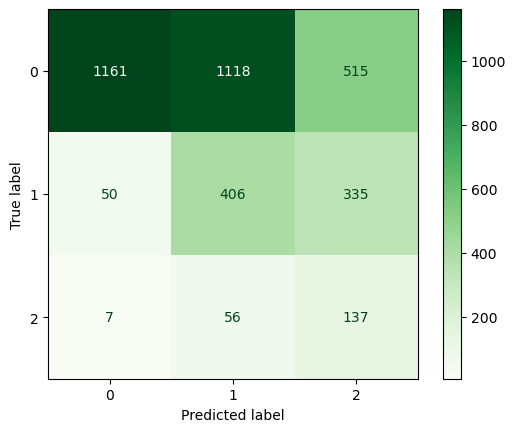

In [14]:
trial_model = foo #Should change the code later.... but eh
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [15]:
custom_recall(y_test, preds, cw_values)

0.6277581120943954

In [24]:
bro = confusion_matrix(y_test, preds)
bro

array([[1161, 1118,  515],
       [  50,  406,  335],
       [   7,   56,  137]], dtype=int64)

In [25]:
sum(bro[2]), sum(bro[1])

(200, 791)

In [26]:
(991-57)/991

0.9424823410696267

In [16]:
hyper_pred_comparer

,cleaned_text,actual,pred,p_0,p_1,p_2
11319,white trash,0,1,0.013821,0.939824,0.046355
5256,ugh i m not say they re the sourc i said they ...,0,0,0.567876,0.296856,0.135268
16919,latina on their way to school url,0,0,0.581017,0.347669,0.071315
39197,awesom group of athlet and i do support their ...,0,0,0.640133,0.134688,0.225179
35367,befor i forget they rape littil boy 2 in europ...,0,1,0.078951,0.572913,0.348136
...,...,...,...,...,...,...
20521,march onward racist too becaus we don t like a...,0,1,0.197211,0.633729,0.169061
30163,thandiswa mawisa a black person is abl to say ...,0,0,0.687453,0.240931,0.071616
25834,cold hoe that s a must bitch bodi a plu bitch ...,0,1,0.025997,0.711919,0.262084
2808,you guy realli are a bunch of faggot here,1,1,0.078266,0.731792,0.189942


In [17]:
hyper_pred_comparer['max_prob'] = hyper_pred_comparer[['p_0','p_1','p_2']].max(axis=1)
hyper_pred_comparer

,cleaned_text,actual,pred,p_0,p_1,p_2,max_prob
11319,white trash,0,1,0.013821,0.939824,0.046355,0.939824
5256,ugh i m not say they re the sourc i said they ...,0,0,0.567876,0.296856,0.135268,0.567876
16919,latina on their way to school url,0,0,0.581017,0.347669,0.071315,0.581017
39197,awesom group of athlet and i do support their ...,0,0,0.640133,0.134688,0.225179,0.640133
35367,befor i forget they rape littil boy 2 in europ...,0,1,0.078951,0.572913,0.348136,0.572913
...,...,...,...,...,...,...,...
20521,march onward racist too becaus we don t like a...,0,1,0.197211,0.633729,0.169061,0.633729
30163,thandiswa mawisa a black person is abl to say ...,0,0,0.687453,0.240931,0.071616,0.687453
25834,cold hoe that s a must bitch bodi a plu bitch ...,0,1,0.025997,0.711919,0.262084,0.711919
2808,you guy realli are a bunch of faggot here,1,1,0.078266,0.731792,0.189942,0.731792


In [18]:
hyper_pred_comparer.iloc[0,2]

1

In [19]:
hyper_pred_comparer['p_2'].describe()

count    3785.000000
mean        0.298754
std         0.215922
min         0.005584
25%         0.126369
50%         0.239242
75%         0.422391
max         0.994436
Name: p_2, dtype: float64

In [21]:
hyper_pred_comparer[hyper_pred_comparer['pred']==1]['p_1'].describe()

count    1580.000000
mean        0.568095
std         0.116949
min         0.337866
25%         0.478188
50%         0.551373
75%         0.643524
max         0.957785
Name: p_1, dtype: float64

In [22]:
hyper_pred_comparer[hyper_pred_comparer['pred']==2]['p_2'].describe()#Hmm, so even within this category we have
#quite a bit of doubt.... thankfully the mean and median are above half,b ut still...

count    987.000000
mean       0.601528
std        0.150055
min        0.338017
25%        0.484154
50%        0.581038
75%        0.702853
max        0.994436
Name: p_2, dtype: float64

Fine, now let's figure out some scenarios:

Let's start out simply:
If 0 we have a majority probability it's fine, but some possibility that it's not. Essentially, it would become
binomial then as the probability it's fin again for a second... nth time decreases. Ie p0**n times p1, 2

So, perhaps we can say if p0 s not that high such that after 5 times a message like this is still not within a certain range then we'd flag it. Cause, the probablity always exists....

Hmm, should I try to do something fancy re. variances?Eh....

Regardless, that would be the approach for 0s.

If 2s (ie plurality....) we could do a few things:
One - Change it's not really a 2, ie give them the benefit of the doubt(0, maybe augmented per 1) for a bit... which wouldn't last long as the probability it's not 2 is low...
Two - Confirm a number more 2s like that until calling for review.

And I guess if 1s the same thing -
However, after thinking about it more,inclined th second approach - assume it for what it is, but give a degree of
tolerance for mistakes/whatever.

Hmm, so, let's say we get a very negative hate post, then what? Perhaps we can start off that if the initial probability is less than .05, etc. of not being 2... Cause, look for example, albeit 1, at the first post in our hyper: 'white trash'...
our model is so confident that it's a 1, almost .94!, yet it's a 0... Likely a lot of context is rmoved, but regardless...

One comment vs many should be the same.

In [ ]:
#Hmm, unsure what to return.... I like percentags so we'll do that for now.
def prob_scanner(p_dominant, category, n=1):
    base = 1-p_dominant
    if base < .05 and category==2:
        print(f"With a probability of {round(p_dominant,3)} we really think the cops should be called.")
    base = round((base**n)*(p_dominant),3)
    if base < 10**-2:#Might want to change threshold for 2s later, in that case...
        if category==2:
            print(f"With a probability of {1-base} we really think the cops should be called.")
        else:
            print(f"With a probability of {1-base}, the students' guardians should be contacted.")
    else:
        print(f"At least for now, with a probability of {1-base} we aren't convinced to monitor this student.")

In [ ]:
user1_logs[
    {'comment':'','pred':'','prob'}
    
    
]

In [ ]:
c = -1

In [ ]:
c += 1
print(c)
print(hyper_pred_comparer.iloc[c,0], hyper_pred_comparer.iloc[c,1], hyper_pred_comparer.iloc[c,2])
prob_scanner(hyper_pred_comparer.iloc[c,6],hyper_pred_comparer.iloc[c,2],1)

In [ ]:
print(c)
print(hyper_pred_comparer.iloc[c,0], hyper_pred_comparer.iloc[c,1], hyper_pred_comparer.iloc[c,2])
prob_scanner(hyper_pred_comparer.iloc[c,6],hyper_pred_comparer.iloc[c,2],6)

In [ ]:
p_dominant = hyper_pred_comparer.iloc[0,4]
base = 1-p_dominant
n= 10

In [ ]:
base = round((base**n)*(p_dominant),3)
base

Great! We have the base down. Now, let's get ready to make it user inputted:

In [ ]:
raw_comment = 'bro mang you a stanky bagel boi zionist'
raw_comment2 = "lul I'm sure after he fired off all those loyal employees he was drinking their blood and tears on Passover #Zionist"
raw_comment3 = 'AND HE STILL DOESNT HAVE ENOUGH MONY TO FIX HIS UGLY GIANT ZIONIST NOSE???'

In [ ]:
user1_logs=[
    {'comment':raw_comment,'occur':1}
    ,{'comment':raw_comment2,'occur':2}
    ,{'comment':raw_comment3,'occur':3}
]

In [ ]:
#Let's start with organizing the cleansngs:
def document_words(raw_document):

    #Remove some various html hiccups that may have crept in.
    document_text = BeautifulSoup(raw_document).get_text()
    
    #Further purge it via regex to keep only characters per Regex. For sure in this case I'm keeping numbers
    letters_only = re.sub("[^a-zA-Z0-9]", " ", document_text)
    #Convert to lower case, split into individual words.
    
    words = letters_only.split()
    words = [w.lower() for w in words]
 
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(i, to_lowercase=False) for i in words]
    
    #And finally, let us merge back everything to a new document.
    return(" ".join(stemmed_words))

In [ ]:
cleaned_comment = document_words(raw_comment2)
cleaned_comment

In [ ]:
user1_logs[0]['comment']

In [ ]:
len(user1_logs)

In [ ]:
sample_comments = [user1_logs[i]['comment'] for i in range(len(user1_logs))]
sample_comments

In [ ]:
# np.array(sample_comments)

In [ ]:
sample = pd.DataFrame(data={'cleaned_comments':sample_comments})
sample

In [ ]:
sample['cleaned_comments'] = sample['cleaned_comments'].apply(document_words)
sample

In [ ]:
preds = trial_model.predict(sample)
preds_prob = trial_model.predict_proba(sample)

In [ ]:
preds = trial_model.predict(sample['cleaned_comments'])
preds_prob = trial_model.predict_proba(sample['cleaned_comments'])
sample_pred_comparer = pd.DataFrame({
    #'cleaned_text':X_test
    #,'actual':y_test
    'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})
sample_pred_comparer['max_prob'] = sample_pred_comparer[['p_0','p_1','p_2']].max(axis=1)
sample_pred_comparer

In [ ]:
sample_pred_comparer['occur'] = [user1_logs[i]['occur'] for i in range(len(user1_logs))]
sample_pred_comparer

We need to go over the cases again:

We see a predicted 0 post. Liklihood that it's iindeed 0 is p0

In [ ]:
def prob_scanner_calc(p_dominant, category, n=1):
    if category!=0:
        q = 1-p_dominant #HMMMM this is technically not true, iewe need it 0 for it to not be actionable... ie so
        #it should b in the 2 case: 1 - p2 -p1... or at least a fraction of p1...
        return round(q**n, 3)
    else: #It actually is a 0, ie the liklihood of seeing htis many comments and it's benign
        return round(p_dominant**n, 3)

In [ ]:
for i in range(sample_pred_comparer.shape[0]):
    print(prob_scanner_calc(sample_pred_comparer.iloc[i]['max_prob'],sample_pred_comparer.iloc[i]['pred'],sample_pred_comparer.iloc[i]['occur']))

In [ ]:
def prob_scanner_account(df):
    overall = 1
    for i in range(df.shape[0]):
        overall *= prob_scanner_calc(df.iloc[i]['max_prob'],df.iloc[i]['pred'],df.iloc[i]['occur'])
    return overall #Ie the probability that all these posts are benign

In [ ]:
prob_scanner_account(sample_pred_comparer)

In [ ]:
#Hmm, so we should have it: make df/csv/whatever of commnts with their frequncy
#2 - run above to get ovrall probability

#What remains would be tinkerng with features such as overall 2 predictions, indv. probabilitys, etc...

In [ ]:
count = -1

In [ ]:
hyper_2 = hyper_pred_comparer[hyper_pred_comparer['pred']==2][['cleaned_text', 'max_prob', 'actual']]

In [ ]:
hyper_2.head()

In [ ]:
count += 1
print(f"{count} is where we're up to.")
print(hyper_2.iloc[count][2])
print(hyper_2.iloc[count][1])
hyper_2.iloc[count][0]


In [ ]:
hyper_2_extreme = hyper_2[hyper_2['max_prob']>.8]
count = -1

In [ ]:
count += 1
print(f"{count} is where we're up to.")
print(hyper_2_extreme.iloc[count][2])
print(hyper_2_extreme.iloc[count][1])
hyper_2_extreme.iloc[count][0]